In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

from PIL import Image
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

2022-02-04 09:10:06.648665: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-02-04 09:10:06.649544: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", train_set_size = 200, test_set_path = "test_set", test_set_size = 50, validation_set_path = "validation_set", validation_set_size = 50, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    #unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = train_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(test_set_path, sample_start = train_set_size + 1, sample_end = train_set_size + test_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(validation_set_path, sample_start = train_set_size + test_set_size + 1, sample_end = train_set_size + test_set_size + validation_set_size, channels = channels, crop_area = crop_area, size = size)

def sample_path(class_name, sample, channel):
    png_path = "dataset8x16/" + class_name + "/CH" + str(channel) + "/sample" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 7)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for i in range(7):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1), "r").crop(crop_area).resize(size)
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(10, 10)
    fig.set_figwidth(20)
    fig.set_figheight(24)
    matrix = np.zeros((size[1], size[0], channels), dtype="uint8")
    for row in range(10):
        for col in range(10):
            if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
            class_name = "P_x" + str(row + 1) + "_y" + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r").crop(crop_area).resize(size))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    tensor = np.zeros((size[1], size[0], channels), dtype="uint8")
    for ch in range(channels):
        img = Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r")
        img = img.crop(crop_area)
        img = img.resize(size)
        tensor[:, :, ch] = np.array(img)
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32), rows = 10, cols = 10, overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(rows):
            for col in range(cols):
                if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
                class_name = "P_x" + str(col + 1) + "_y" + str(row + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "sample_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i, channels = channels, crop_area = crop_area, size = size)
                    np.save(file_name, tensor)

def create_labeled_data(srs_path = "tensors", label_type = "categorical"):
    labeled_data = []
    categories = os.listdir(srs_path)
    categories.sort()
    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = P_x10_y2, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])

    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    if label_type == "regression":
        Y = to_regression(Y, categories)
    else:
        Y = np.array(Y)
        np.reshape(Y, (len(Y), 1))
        Y = to_categorical(Y)

    return X, Y

def to_regression(categorical_labels, categories):
    tensor = np.zeros((len(categorical_labels), 2))
    for i in range(len(categorical_labels)):
        category_name = categories[categorical_labels[i]]

        x_i = int(category_name.split("_")[1].split("x")[1]) - 1
        y_i = int(category_name.split("_")[2].split("y")[1]) - 1

        x_pos = 0.0935 * x_i + 0.012
        y_pos = 0.0973 * y_i + 0.012
        tensor[i,:] = [x_pos, y_pos]
    return tensor

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

def optimization_plot(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

def train_model(model, model_file_name = "model.h5", target_accuracy = 0.90):
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)

    current_accuracy = 0
    while (current_accuracy < target_accuracy):
        history = model.fit(train_X, train_Y, epochs=100, batch_size=10, validation_data=(test_X, test_Y), verbose=1, callbacks=[monitor])
        _, validation_accuracy = model.evaluate(val_X, val_Y, verbose=1)
        if (current_accuracy < validation_accuracy):
            print("Validation accuracy > {:.2f}".format(validation_accuracy * 100.0))
            print("Saving model > {}".format(model_file_name))
            model.save(model_file_name)
            optimization_plot(history, "optimization")
            current_accuracy = validation_accuracy
        else:
            if os.path.exists(model_file_name):
                model = load_model(model_file_name)

    print("Done!")

In [3]:
def CNN_regression(input_shape = (32, 32, 4), output_regression = 2):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_regression, activation='sigmoid'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def CNN_categorical(input_shape = (32, 32, 4), output_categories = 16):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(output_categories, activation='softmax'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
zip_data_path = "dataset8x16.zip"

train_set_path = "train_set"
train_set_size = 1700

test_set_path = "test_set"
test_set_size = 400

validation_set_path = "validation_set"
validation_set_size = 400

crop_area = (0, 0, 16, 8) # x1, y1, x2, y2
size = (16, 8)

channel_sensors = 7
 
generate_datasets ( zip_data_path = zip_data_path,\
                    train_set_path = train_set_path,\
                    train_set_size = train_set_size,\
                    test_set_path = test_set_path,\
                    test_set_size = test_set_size,\
                    validation_set_path = validation_set_path,\
                    validation_set_size = validation_set_size,\
                    channels = channel_sensors, crop_area = crop_area, size = size)

In [6]:
model_type = "regression" # set "regression" or "categorical"

train_X, train_Y = create_labeled_data(srs_path = train_set_path, label_type = model_type)
test_X, test_Y = create_labeled_data(srs_path = test_set_path, label_type = model_type)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path, label_type = model_type)


In [7]:
if model_type == "regression":
    model = CNN_regression(input_shape = (size[1], size[0], channel_sensors))
else:
    model = CNN_categorical(input_shape = (size[1], size[0], channel_sensors), output_categories = 16)

2022-02-04 09:28:46.575581: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-02-04 09:28:46.656243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 09:28:46.658794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 860M computeCapability: 5.0
coreClock: 1.0195GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2022-02-04 09:28:46.663201: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-02-04 09:28:46.665100: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libc

In [8]:
model_file_name = "model_8x16x7.h5" # Set the file name for the model
target_accuracy = 0.99

train_model(model, model_file_name, target_accuracy)

2022-02-04 09:28:47.093475: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 584908800 exceeds 10% of free system memory.


Epoch 1/100
16319/16320 [============================>.] - ETA: 0s - loss: 0.5376 - accuracy: 0.9321

2022-02-04 09:30:12.623856: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 137625600 exceeds 10% of free system memory.


16320/16320 [==============================] - 90s 6ms/step - loss: 0.5376 - accuracy: 0.9321 - val_loss: 0.5250 - val_accuracy: 0.9579
Epoch 2/100
16320/16320 [==============================] - 93s 6ms/step - loss: 0.5276 - accuracy: 0.9568 - val_loss: 0.5243 - val_accuracy: 0.9815
Epoch 3/100
16320/16320 [==============================] - 92s 6ms/step - loss: 0.5264 - accuracy: 0.9662 - val_loss: 0.5239 - val_accuracy: 0.9880
Epoch 4/100
16320/16320 [==============================] - 114s 7ms/step - loss: 0.5258 - accuracy: 0.9685 - val_loss: 0.5235 - val_accuracy: 0.9916
Epoch 5/100
16320/16320 [==============================] - 118s 7ms/step - loss: 0.5254 - accuracy: 0.9723 - val_loss: 0.5233 - val_accuracy: 0.9918
Epoch 6/100
16320/16320 [==============================] - 121s 7ms/step - loss: 0.5252 - accuracy: 0.9746 - val_loss: 0.5235 - val_accuracy: 0.9882
Epoch 7/100
16320/16320 [==============================] - 124s 8ms/step - loss: 0.5250 - accuracy: 0.9741 - val_loss: 0.

2022-02-04 09:54:13.645294: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 137625600 exceeds 10% of free system memory.


1200/1200 [==============================] - 5s 4ms/step - loss: 0.5238 - accuracy: 0.9878
Validation accuracy > 98.78
Saving model > model_8x16x7.h5


2022-02-04 09:54:20.198496: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 584908800 exceeds 10% of free system memory.


Epoch 1/100
16319/16320 [============================>.] - ETA: 0s - loss: 0.5258 - accuracy: 0.9672

2022-02-04 09:56:12.126971: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 137625600 exceeds 10% of free system memory.


16320/16320 [==============================] - 117s 7ms/step - loss: 0.5258 - accuracy: 0.9672 - val_loss: 0.5237 - val_accuracy: 0.9919
Epoch 2/100
16320/16320 [==============================] - 113s 7ms/step - loss: 0.5255 - accuracy: 0.9706 - val_loss: 0.5234 - val_accuracy: 0.9904
Epoch 3/100
16320/16320 [==============================] - 128s 8ms/step - loss: 0.5252 - accuracy: 0.9721 - val_loss: 0.5235 - val_accuracy: 0.9967
Epoch 4/100
16320/16320 [==============================] - 142s 9ms/step - loss: 0.5250 - accuracy: 0.9744 - val_loss: 0.5233 - val_accuracy: 0.9951
Epoch 5/100
 9109/16320 [===============>..............] - ETA: 54s - loss: 0.5246 - accuracy: 0.9738

In [ ]:
def compute_error(error_tensor):
    mse = ((error_tensor)**2).mean(axis=None)
    max_error = np.max(error_tensor)
    ave_error = sum(error_tensor) / len(error_tensor)
    return mse, max_error, ave_error

model = load_model(model_file_name)

model_output = model.predict(val_X)

error_tensor = val_Y - model_output

error_x_tensor = error_tensor[:,0]
error_y_tensor = error_tensor[:,1]

mse_x, max_error_x, ave_error_x = compute_error(error_x_tensor)
mse_y, max_error_y, ave_error_y = compute_error(error_y_tensor)

print("MSE = ({}, {})".format(mse_x, mse_y))
print("Ave error = ({}, {})".format(ave_error_x, ave_error_y))
print("Max error = ({}, {})".format(max_error_x, max_error_y))

MSE = (0.00016771570927155778, 0.00013413217239241758)
Ave error = (0.007871481879614731, -0.0019281041896280031)
Max error = (0.05359962487220765, 0.035271206092834406)


In [ ]:
file = validation_set_path + "/P_x1_y2/sample_2251.npy"

sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(model_file_name)

model_output = model.predict(sample)

if model_type == "regression":
    print("Input sample = {}, model prediction = {}".format(file, model_output))
else:
    print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

Input sample = validation_set/P_x1_y2/sample_2251.npy, model prediction = [[0.0114083  0.13174784]]


In [ ]:
model = load_model(model_file_name)

model.summary()

tf.keras.utils.plot_model(model, model_file_name + ".png", show_shapes=True, show_layer_names=True, expand_nested=True)

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.inference_input_type = tf.float32  # or tf.uint8
converter.inference_output_type = tf.float32  # or tf.uint8
tflite_model = converter.convert()

# Save the model.
with open(model_file_name + '.tflite', 'wb') as f:
  f.write(tflite_model)

os.system("xxd -i " + model_file_name + '.tflite' + " > " + model_file_name + '.cpp')

print("Done!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 16, 40)         2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 16, 40)         160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 40)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 8, 40)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 8, 60)          21660     
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 8, 60)          240       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 4, 60)          0

2022-02-04 03:42:08.124155: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp7o6kx9w8/assets


2022-02-04 03:42:10.478993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 03:42:10.482101: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-02-04 03:42:10.482209: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-02-04 03:42:10.618479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 03:42:10.620453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fe0daddcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-02-04 03:42:10.620473: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce GT

Done!


2022-02-04 03:42:10.848983: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:313] Ignored output_format.
2022-02-04 03:42:10.849018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored drop_control_dependency.
2022-02-04 03:42:10.894791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 03:42:10.895582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 860M computeCapability: 5.0
coreClock: 1.0195GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2022-02-04 03:42:10.895718: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-02-04 

Grid (sample = 280, channels = 3)


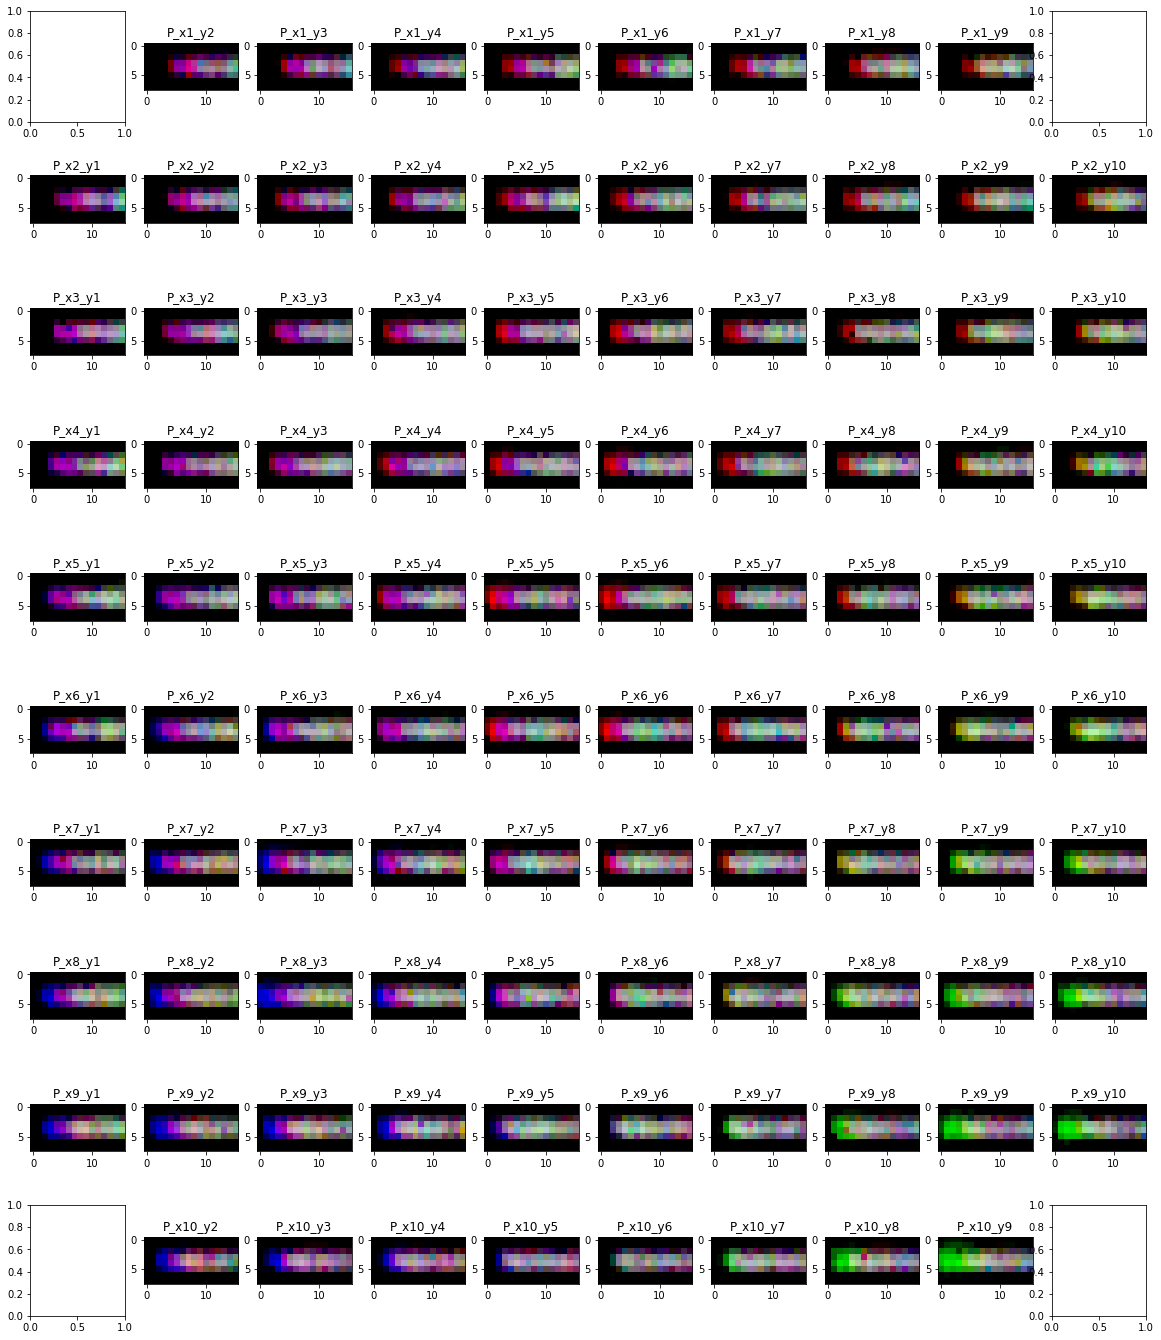

In [ ]:
show_grid(sample = 280, channels = 3, crop_area = crop_area, size = size)

Sample = 280, class = P_x10_y9


/tmp/ipykernel_13732/2722977234.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


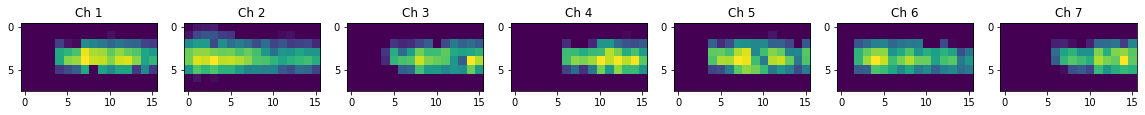

In [ ]:
show_sample(class_name = "P_x10_y9", sample = 280, crop_area = crop_area, size = size)